# Classification de documents : prise en main des outils

Le but de ce TP est de classer des documents textuels... Dans un premier temps, nous allons vérifier le bon fonctionnement des outils sur des données jouets puis appliquer les concepts sur des données réelles.


## Conception de la chaine de traitement
Pour rappel, une chaine de traitement de documents classique est composée des étapes suivantes:
1. Lecture des données et importation
    - Dans le cadre de nos TP, nous faisons l'hypothèse que le alltxts tient en mémoire... Si ce n'est pas le cas, il faut alors ajouter des structures de données avec des buffers (*data-reader*), bien plus complexes à mettre en place.
    - Le plus grand piège concerne l'encodage des données. Dans le TP... Pas (ou peu) de problème. Dans la vraie vie: il faut faire attention à toujours maitriser les formats d'entrée et de sortie.
1. Traitement des données brutes paramétrique. Chaque traitement doit être activable ou desactivable + paramétrable si besoin.
    - Enlever les informations *inutiles* : chiffre, ponctuations, majuscules, etc... <BR>
    **L'utilité dépend de l'application!**
    - Segmenter en mots (=*Tokenization*)
    - Elimination des stop-words
    - Stemming/lemmatisation (racinisation)
    - Byte-pair encoding pour trouver les mots composés (e.g. Sorbonne Université, Ville de Paris, Premier Ministre, etc...)
1. Traitement des données numériques
    - Normalisation *term-frequency* / binarisation
    - Normalisation *inverse document frequency*
    - Elimination des mots rares, des mots trop fréquents
    - Construction de critère de séparabilité pour éliminer des mots etc...
1. Apprentissage d'un classifieur
    - Choix du type de classifieur
    - Réglage des paramètres du classifieur (régularisation, etc...)

## Exploitation de la chaine de traitement

On appelle cette étape la réalisation d'une campagne d'expériences: c'est le point clé que nous voulons traviller en TAL cette année.
1. Il est impossible de tester toutes les combinaisons par rapport aux propositions ci-dessus... Il faut donc en éliminer un certain nombre.
    - En discutant avec les experts métiers
    - En faisant des tests préliminaires
1. Après ce premier filtrage, il faut:
    - Choisir une évaluation fiable et pas trop lente (validation croisée, leave-one-out, split apprentissage/test simple)
    - Lancer des expériences en grand
        - = *grid-search*
        - parallèliser sur plusieurs machines
        - savoir lancer sur un serveur et se déconnecter
1. Collecter et analyser les résultats


## Inférence

L'inférence est ensuite très classique: la chaine de traitement optimale est apte à traiter de nouveaux documents

# Etape 1: charger les données

In [52]:

from collections import Counter

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import codecs
import re
import os.path

from sklearn.model_selection import train_test_split
"""
import nltk 
from nltk import sent_tokenize
from nltk import word_tokenize"""

'\nimport nltk \nfrom nltk import sent_tokenize\nfrom nltk import word_tokenize'

In [53]:
# Chargement des données:
def load_pres(fname):
    alltxts = []
    alllabs = []
    s=codecs.open(fname, 'r','utf-8') # pour régler le codage
    while True:
        txt = s.readline()
        if(len(txt))<5:
            break
        #
        lab = re.sub(r"<[0-9]*:[0-9]*:(.)>.*","\\1",txt)
        txt = re.sub(r"<[0-9]*:[0-9]*:.>(.*)","\\1",txt)
        if lab.count('M') >0:
            alllabs.append(-1)
        else: 
            alllabs.append(1)
        alltxts.append(txt)
    return alltxts,alllabs


#### IMPORTER LES DEUX DATASET: test and test 

In [89]:
#fname = "ressources\AFDpresidentutf8\corpus.tache1.learn.utf8"
path_train= r"C:\Users\actou\OneDrive\Documents\IODAA\ONTO-TAL\TAL\tuto_TAL-main\notebooks\ressources\AFDpresidentutf8\corpus.tache1.learn.utf8"
alltxts,alllabs = load_pres(path_train)

print("la longueur du training data_set est de:",len(alltxts),len(alllabs))
print(alltxts[0])
print(alllabs[0])
print(alltxts[-1])
print(alllabs[-1])

print(len(alltxts),len(alllabs))

path_test= r"C:\Users\actou\OneDrive\Documents\IODAA\ONTO-TAL\TAL\tuto_TAL-main\notebooks\ressources\AFDpresidentutf8\corpus.tache1.test.utf8"
#text = open("ressources/AFDpresidentutf8/corpus.tache1.test.utf8",encoding="utf-8")
test_alltxts,test_alllabs = load_pres(path_test)

print("la longueur du data_set test est de:",len(test_alltxts),len(test_alllabs))
print(test_alltxts[0])
print(test_alllabs[10])
print(test_alltxts[-1])
print(test_alllabs[1000])


la longueur du training data_set est de: 57413 57413
 Quand je dis chers amis, il ne s'agit pas là d'une formule diplomatique, mais de l'expression de ce que je ressens.

1
 Je compte sur vous.

1
57413 57413
la longueur du data_set test est de: 27162 27162
<105:1> En répondant à votre invitation, en effectuant cette première visite d'Etat d'un Président français en Algérie depuis l'indépendance, j'ai conscience d'ouvrir avec vous un chapitre nouveau de notre histoire commune, le chapitre de la confiance, de l'estime, du respect mutuel, de l'amitié et de la solidarité.

1
<823:34> Dans cette perspective, je demanderai à une grande personnalité de l'industrie de me faire des propositions sur les moyens de renforcer la coopération scientifique et industrielle avec les pays émergents, les transferts de technologie vers ces pays et le financement de leur développement propre.

1




Vous devez tester, par exemple, les cas suivants:
- transformation en minuscule ou pas
- suppression de la ponctuation
- transformation des mots entièrement en majuscule en marqueurs spécifiques
- suppression des chiffres ou pas
- conservation d'une partie du texte seulement (seulement la première ligne = titre, seulement la dernière ligne = résumé, ...)
- stemming
- ...


Vérifier systématiquement sur un exemple ou deux le bon fonctionnement des méthodes sur deux documents (au moins un de chaque classe).

In [90]:
 from collections import Counter
'''
counter_train = Counter((x[1] for x in train_alltxts))
counter_test = Counter((x[1] for x in test_alltxts))

print("Number of train reviews : ", len(train_alltxts))
print("----> # of positive : ", counter_train[1])
print("----> # of negative : ", counter_train[0])
print("")
print(train_alllabs[0])

print("")
print("Number of test reviews : ",len(test_alllabs))
print("----> # of positive : ", counter_test[1])
print("----> # of negative : ", counter_test[0])

print("")
print(test_alllabs[0])
print("")
''' 

''' 
from sklearn.model_selection import train_test_split
traintxts, testtxts, trainlabs, testlabs = train_test_split(train_alltxts, train_alllabs, test_size=0.3, random_state=0) 
print(len(traintxts))
print(len(testtxts))

'''
traintxts = alltxts
trainlabs = alllabs

In [56]:
''' # Let's plot the count of the 1000 most used words:
pres_train=open("ressources/AFDpresidentutf8/alltxts.tache1.learn.utf8")
lines_train=pres_train.readlines()
pres_test=open("ressources/AFDpresidentutf8/alltxts.tache1.test.utf8")
lines_test=pres_test.readlines()

import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter 

wc = Counter()
for text,pol in lines_train+lines_train:
    wc.update(text.split(" "))
    
freq = [f for w,f in wc.most_common(100)]

plt.plot(freq[:100])
print(wc.most_common(19)) ## enlever les 19 premiers 
'''

' # Let\'s plot the count of the 1000 most used words:\npres_train=open("ressources/AFDpresidentutf8/alltxts.tache1.learn.utf8")\nlines_train=pres_train.readlines()\npres_test=open("ressources/AFDpresidentutf8/alltxts.tache1.test.utf8")\nlines_test=pres_test.readlines()\n\nimport matplotlib.pyplot as plt\n%matplotlib inline\nfrom collections import Counter \n\nwc = Counter()\nfor text,pol in lines_train+lines_train:\n    wc.update(text.split(" "))\n    \nfreq = [f for w,f in wc.most_common(100)]\n\nplt.plot(freq[:100])\nprint(wc.most_common(19)) ## enlever les 19 premiers \n'

### 3 - Transformation paramétrique du texte
- 1 - Supprimer la ponctuation 
- 2 - Mettre en minuscule \
- 3 - Supprimer les nombres # semble inutile pour les nombres 
- 4 - Supprimer les accents 
- 5 - Normaliser les caractères 

In [91]:
import string
import re
import unicodedata
def pretraitement(string):
    punc = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
    for element in string:  
        if element in punc:  
            string = string.replace(element, "") 
            string = string.lower()
            string = re.sub('[0-9]+', '', string)
            string = unicodedata.normalize('NFD',string).encode('ascii', 'ignore').decode("utf-8")
    return string
    
traintxts= [pretraitement(i) for i in alltxts]
print(traintxts[:1]) # cleaned list
print(len(traintxts))

[' quand je dis chers amis il ne sagit pas la dune formule diplomatique mais de lexpression de ce que je ressens\n']
57413


### 4 - Extraction du vocabulaire

Exploration préliminaire des jeux de données.

- 1- Quelle est la taille d'origine du vocabulaire?
- 2-  Que reste-t-il si on ne garde que les 100 mots les plus fréquents? [word cloud]
- 3 - Quels sont les 100 mots dont la fréquence documentaire est la plus grande? [word cloud]
- 4 - Quels sont les 100 mots les plus discriminants au sens de odds ratio? [word cloud]
- 5 - Quelle est la distribution d'apparition des mots (Zipf)
- 6 -Quels sont les 100 bigrammes/trigrammes les plus fréquents?

In [92]:
from collections import Counter
word=[]
for sentence in traintxts:
        word += sentence.split()

dico = Counter(word)       
print("la taille du dico",len(dico))

trans = dict(zip(list(dico.keys()), np.arange(len(dico)).tolist()))
#print(trans)

from scipy.sparse import coo_matrix

d = np.zeros(len(trans))
for m in word:
    d[trans[m]] += 1
ds = coo_matrix(d)
#print(ds[10])

la taille du dico 32011


###  2 - Mots les plus fréquents (quel nombre choisir?)

Text(0.5, 1.0, '100 mots les plus frequents')

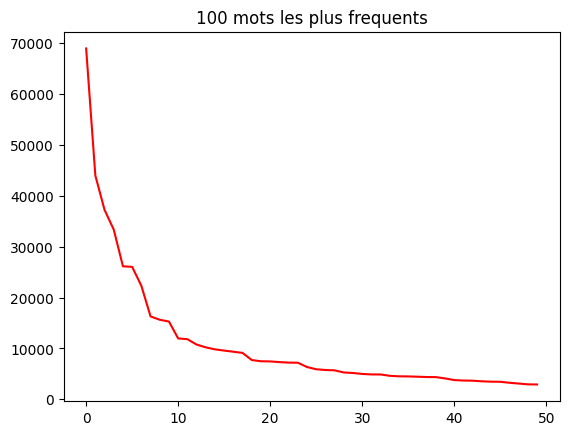

In [81]:
### Let's plot the count of the 1000 most used words:

liste_most_common=[mot for mot,freq in dico.most_common(50)]
liste_freq= [freq for mot,freq in dico.most_common(50)]
plt.plot(liste_freq[:100],color='red')
plt.title('100 mots les plus frequents')


In [93]:
traintxts2=[]
for sentence in traintxts: 
    mots = sentence.split()
    for mot in mots:
        if mot in liste_most_common:
            mots.remove(mot)
    new_phrase=" ".join(mots)
    traintxts2.append(new_phrase)

#print(traintxts2[:100])

traintxts = traintxts2
print(len(traintxts))

57413


In [ ]:

# CountVectorizer can take a list of stop words as argument.
# Build or download a list of stop word (from NLTK for exemple)
#stop_words = ["the", "a", "and"] #Make a better list
#stop_words = [w for w , n in wc.most_common(19)] ### rmv les stopwords

from sklearn.feature_extraction.text import CountVectorizer

vectorizer_1  = CountVectorizer(stop_words=liste_most_common)
X1= vectorizer_1.fit_transform(traintxts)
print(vectorizer_1.get_feature_names()[:100]) # we only print a few
dic_size = np.shape(X1.toarray()[1])
#print(X4.toarray())
#print(X4.shape)
#print(len(alllabs))
print(" ")
print("Supprimer les stop word (500 mots les plus frequents")
print("    --> la taille du dictionnaire est",dic_size)
print(X1.shape)
print("la longueur de alllabs est",len(alllabs))

vectorizer_2  = CountVectorizer(max_df=0.005, min_df=7)
X2= vectorizer_2.fit_transform(traintxts)
dic_size = np.shape(X2.toarray()[1])
print(" ")
print("Tester plusieurs valeurs de max_df et  min_df")
print("    --> Min.df = 7 et Max df = 0.005 --> la taille du dictionnaire est",dic_size)

vectorizer_3  = CountVectorizer(max_df=0.05, min_df=7)
X3= vectorizer_3.fit_transform(traintxts)
dic_size = np.shape(X3.toarray()[1])
print(" ")
print("Tester plusieurs valeurs de max_df et  min_df")
print("    --> Min.df = 7 et Max df = 0.05 --> la taille du dictionnaire est",dic_size)

vectorizer_4  = CountVectorizer(max_df=0.005, min_df=15)
X3= vectorizer_3.fit_transform(traintxts)
dic_size = np.shape(X3.toarray()[1])
print(" ")
print("Tester plusieurs valeurs de max_df et  min_df")
print("    --> Min.df = 15 et Max df = 0.005 --> la taille du dictionnaire est",dic_size)

vectorizer_4  = CountVectorizer(stop_words=stop_words,max_df=0.005, min_df=7)
X4= vectorizer_4.fit_transform(traintxts)
dic_size = np.shape(X4.toarray()[1])
print(" ")
print("Enlever les stop_word + Tester valeurs de max_df et  min_df")
print("    --> Min.df = 7 et Max df = 0.005 --> la taille du dictionnaire est",dic_size)


Quels sont les 100 mots dont la fréquence documentaire est la plus grande? [word cloud]
- Quels sont les 100 mots les plus discriminants au sens de odds ratio? [word cloud]
- Quelle est la distribution d'apparition des mots (Zipf)
- Quels sont les 100 bigrammes/trigrammes les plus fréquents?


Question qui devient de plus en plus intéressante avec les approches modernes:
est-il possible d'extraire des tri-grammes de lettres pour représenter nos documents?

Quelle performances attendrent? Quels sont les avantages et les inconvénients d'une telle approche?

# Modèles de Machine Learning

Avant de lancer de grandes expériences, il faut se construire une base de travail solide en étudiant les questions suivantes:

- Combien de temps ça prend d'apprendre un classifieur NB/SVM/RegLog sur ces données en fonction de la taille du vocabulaire?
- La validation croisée est-elle nécessaire? Est ce qu'on obtient les mêmes résultats avec un simple *split*?
- La validation croisée est-elle stable? A partir de combien de fold (travailler avec différentes graines aléatoires et faire des statistiques basiques)?

In [109]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score

print(len(trainlabs))
print(len(traintxts))


#Naïve Bayes
nb_clf = MultinomialNB()
nb_clf.fit(X4, trainlabs)

#Logistic Regression
lr_clf = LogisticRegression(random_state=0, solver='lbfgs',n_jobs=-1)
lr_clf.fit(X4, trainlabs)

#Linear SVM
svm_clf = LinearSVC(random_state=0, tol=1e-5)
svm_clf.fit(X4, trainlabs)

#true = [pol for text,pol in test]
#test_alltxts = [text for text,pol in test]
X_test = vectorizer_4.transform(traintxts)
#print(X_test[10])
pred_nb = nb_clf.predict(X_test)
pred_lr = lr_clf.predict(X_test)
pred_svm = svm_clf.predict(X_test)

print ("ACCURACY :")
print(f"    Naïve Bayes accuracy: {accuracy_score(trainlabs, pred_nb)}")
print(f"    Logistic Regression accuracy: {accuracy_score(trainlabs, pred_lr)}")
print(f"    SVM accuracy: {accuracy_score(trainlabs, pred_svm)}")

print ("RECALL :")
print(f"    Naïve Bayes : {recall_score(alllabs, pred_nb)}")
print(f"    Logistic Regression {recall_score(alllabs, pred_lr)}")
print(f"    SVM : {recall_score(alllabs, pred_svm)}")


57413
57413
ACCURACY :
    Naïve Bayes accuracy: 0.9076864124849773
    Logistic Regression accuracy: 0.9190775608311706
    SVM accuracy: 0.93421350565203
RECALL :
    Naïve Bayes : 0.9666265784726398
    Logistic Regression 0.9924634195229505
    SVM : 0.9883744237322108


## Première campagne d'expériences

Les techniques sur lesquelles nous travaillons étant sujettes au sur-apprentissage: trouver le paramètre de régularisation dans la documentation et optimiser ce paramètre au sens de la métrique qui vous semble la plus appropriée (cf question précédente).

## Equilibrage des données

Un problème reconnu comme dur dans la communauté est celui de l'équilibrage des alllabs (*balance* en anglais). Que faire si les données sont à 80, 90 ou 99% dans une des alllabs?
Le problème est dur mais fréquent; les solutions sont multiples mais on peut isoler 3 grandes familles de solution.

1. Ré-équilibrer le jeu de données: supprimer des données dans la classe majoritaire et/ou sur-échantilloner la classe minoritaire.<BR>
   $\Rightarrow$ A vous de jouer pour cette technique
1. Changer la formulation de la fonction de coût pour pénaliser plus les erreurs dans la classe minoritaire:
soit une fonction $\Delta$ mesurant les écarts entre $f(x_i)$ et $y_i$ 
$$C = \sum_i  \alpha_i \Delta(f(x_i),y_i), \qquad \alpha_i = \left\{
\begin{array}{ll}
1 & \text{si } y_i \in \text{classe majoritaire}\\
B>1 & \text{si } y_i \in \text{classe minoritaire}\\
\end{array} \right.$$
<BR>
   $\Rightarrow$ Les SVM et d'autres approches sklearn possèdent des arguments pour régler $B$ ou $1/B$... Ces arguments sont utiles mais pas toujours suffisant.
1. Courbe ROC et modification du biais. Une fois la fonction $\hat y = f(x)$ apprise, il est possible de la *bidouiller* a posteriori: si toutes les prédictions $\hat y$ sont dans une classe, on va introduire $b$ dans $\hat y = f(x) + b$ et le faire varier jusqu'à ce qu'un des points change de classe. On peut ensuite aller de plus en plus loin.
Le calcul de l'ensemble des scores associés à cette approche mène directement à la courbe ROC.

**Note:** certains classifieurs sont intrinsèquement plus résistante au problème d'équilibrage, c'est par exemple le cas des techniques de gradient boosting que vous verrez l'an prochain.

In [110]:
### METHODE 1 - evaluate: cross validation with balanced set
X = alltxts
y = alllabs
nb_1= []
for i in y:
    if i == 1:
        nb_1.append(1)
ratio = len(nb_1)/len(y)*100
print("le ratio de 1 est :",ratio,"%")
print("le ratio de (-1) est :", 100-ratio,"%")
if ratio - (1-ratio) > 40:
    print(" --> vos classes son désequilibrées, votre classifieur prédit donc toujours la classe la plus courante avec un taux de précision élevé mais mauvais --> vous pouvez réchantillonner, ... bon après-midi")
    print(" on applique l'oversampling")

le ratio de 1 est : 86.89669587027329 %
le ratio de (-1) est : 13.103304129726709 %
 --> vos classes son désequilibrées, votre classifieur prédit donc toujours la classe la plus courante avec un taux de précision élevé mais mauvais --> vous pouvez réchantillonner, ... bon après-midi
 on applique l'oversampling


In [ ]:
# lien pour le réquilibrage des données
## https://imbalanced-learn.org/stable/over_sampling.html#naive-random-over-sampling

